Let's start by importing the libraries and class that we will need.

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#import required Libraries
import pandas as pd
import numpy as np

import os 
pd.set_option('display.max_colwidth', -1)
import requests
import io

# Import the stats library
from scipy import stats

import statsmodels.api as sm

# These are the plotting libraries we'll use:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.style.use("classic")
import seaborn as sns

#Machine learning
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score


# Command for plots to appear in the iPython Notebook
%matplotlib inline

/Users/Shravan/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Next, let's import the pickeled dataset

In [2]:
modelingdata = pd.read_pickle('modelingdata.pickle')

In [3]:
modelingdata.shape

(2579, 268)

The first step in ML is for the model to learn the relationship between the features and the response. Our first task is make sure that the features and the response are in the form that scikit-learn expects. There are 4 key requirements to keep in mind, which are as follows:

1. Features and response are separate objects.
2. Features and response should be numeric
3. Features and response should be NumPy arrays.
4. Features and response should have specific shapes.

In order to meet our first requirement, we need to break up the dataframe into features and response.

In [4]:
# Create feature object
df_X = modelingdata.copy()
# Create target = Y
df_y = df_X.summer_program_flg

print('X shape before ')
print(df_X.shape)

#drop the response column from the x dataset
df_X.pop('summer_program_flg')

print('X shape after ')
print(df_X.shape)
print('Y shape after ')
print(df_y.shape)

X shape before 
(2579, 268)
X shape after 
(2579, 267)
Y shape after 
(2579,)


Second requirement is that scikit-learn is only expecting to see numbers. So we need to convert the non-numeric features to dummy-encoded features. 

In [5]:
def dummy_Create(df):
    schoolDataFinal = df.copy()
    SchoolDataCat = schoolDataFinal.loc[:,(schoolDataFinal.dtypes == bool)| (schoolDataFinal.dtypes == object) |(schoolDataFinal.dtypes == 'category')]#.columnscategory
    # drop the two street address columns
    try: 
        SchoolDataCat.pop('street_ad')
        SchoolDataCat.pop('scity_ad')
    except Exception as e:
        print(e.args)
    print(SchoolDataCat.columns)
    cat_vars=SchoolDataCat.columns
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(schoolDataFinal[var], prefix=var)
        df=pd.concat([df,cat_list], axis=1)
    data=df
    cat_vars=SchoolDataCat.columns
    data_vars=data.columns.values.tolist()
    
    to_keep=[i for i in data_vars if i not in cat_vars]

    ## Final data columns
    data_final=data[to_keep]
    try:
        data_final.pop('street_ad')
        data_final.pop('scity_ad')
    except Exception as e:
        print(e.args)
    data_final.columns.values
    data_final_vars=data_final.columns.values.tolist()
    #return(SchoolDataCat)
    y=['summer_program_flg']
    X=[i for i in data_final_vars if i not in y]
 
    list(data_final_vars)
    print(y)
    print(X)
    return(data_final.abs())
    
df_X = dummy_Create(df_X)

Index(['grades_1_to_1_access', 'type_cd_txt', 'Reading SPG Grade', 'Byod',
       'Grad_project_status', 'esea_status', 'school_type_txt',
       'Math SPG Grade', 'Closed_Ind_Text', 'category_cd', 'state_ad',
       '1_to_1_access', 'grades_BYOD', 'State Gap Compared',
       'EVAAS Growth Status', 'calendar_only_txt', 'SPG Grade', 'New_ind_Txt',
       'Overall_Achievement_Score_bins'],
      dtype='object')
['summer_program_flg']
['avg_age_media_collection', 'Read Score', 'Avg_State_Size_EnglishII', 'lea_cte_courses', 'szip_ad', 'st_wap_num', 'sat_participation_pct', 'st_total_specialized_courses', 'Avg_Dist_Size_04', 'st_supplies_expense_pct', 'RETAINED_School_Pct', 'Avg_Class_Size_07', 'services_expense_pct', 'st_long_susp_per_c_num', 'Avg_Class_Size_04', 'st_prinyrs_0thru3_pct', 'st_emer_prov_teach_pct', 'other_expense_pct', 'Avg_Class_Size_00', 'GCE_ALL_School_Pct', 'st_wap_per_classroom', 'lea_sat_participation_pct', 'books_per_student', 'Avg_Class_Size_Biology', 'GCE_RPF_Schoo

In [6]:
print(df_X.shape)
print(df_y.shape)

(2579, 397)
(2579,)


Let's see the class distribution

In [7]:
df_y.value_counts()

 0    1702
-1    877 
Name: summer_program_flg, dtype: int64

There is some imbalance of the class variable, with 66% belonging to class 0 and 34% belonging to class 1. Whenever we have class imbalance, it might be useful to calculate the accuracy of the **Null Model** - that is, what if our estimator always predicted the majority class ? 

In [8]:
max(abs(df_y.mean()), 1 - abs(df_y.mean()))

0.6599457153935634

### Create a logistic regression model and a support vector machine model for the classification task involved with your dataset.

### Assess how well each model performs (use 80/20 training/testing split for your data)

Let's start by building a Logistic regression model for predicting summer_program_flg (?) using all the features.

In [9]:
# STEP 1: split df_X and df_y into training and testing sets
from sklearn.model_selection import train_test_split
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=4)

In [10]:
print(df_X_train.shape)
print(df_X_test.shape)

(2063, 397)
(516, 397)


In [11]:
print(df_y_train.shape)
print(df_y_test.shape)

(2063,)
(516,)


In [12]:
# STEP 2: train the model on the training set
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(df_X_train, df_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
# STEP 3: make predictions on the testing set
y_pred = logreg.predict(df_X_test)

In [14]:
# Compute the prediction accuracy
from sklearn import metrics
print(metrics.accuracy_score(df_y_test, y_pred))

0.72480620155


In [15]:
# Calculate predicted probabilities 
y_pred_prob = logreg.predict_proba(df_X_test)[:,1]

neg_df_y_test = -df_y_test

# Calculate AUC
print(metrics.roc_auc_score(neg_df_y_test, y_pred_prob))

0.225779159112


### SVM

In [16]:
# STEP 1: split df_X and df_y into training and testing sets
from sklearn.model_selection import train_test_split
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=4)

In [17]:
# STEP 2: train the model on the training set
from sklearn.svm import SVC
svc = SVC()
svc.fit(df_X_train, df_y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
# STEP 3: make predictions on the testing set
y_pred_svc = svc.predict(df_X_test)

In [19]:
# Compute the prediction accuracy
from sklearn import metrics
print(metrics.accuracy_score(df_y_test, y_pred_svc))

0.68023255814


### Tuning SVM

We can tune two key parameters of the SVM algorithm, the value of C (how much to relax the margin) and the type of kernel. The default for SVM (the SVC class) is to use the Radial Basis Function (RBF) kernel with a C value set to 1.0. We will use `linear` kernel and vary the C value to see if that improves our model.

In [20]:
# Train the model with kerner = `linear` and default C value.
svc = SVC(kernel='linear')
svc.fit(df_X_train, df_y_train)
y_pred_svc = svc.predict(df_X_test)
print(metrics.accuracy_score(df_y_test, y_pred_svc))

0.718992248062


In [21]:
# Train the model with kerner = `linear` and default C value.
svc = SVC(C=1.5, kernel='linear')
svc.fit(df_X_train, df_y_train)
y_pred_svc = svc.predict(df_X_test)
print(metrics.accuracy_score(df_y_test, y_pred_svc))

0.726744186047


## Comparing Logistic Regression with SVM

The key to a fair comparison of machine learning algorithms is ensuring that each algorithm is evaluated in the same way on the same data. We can achieve this by forcing each algorithm to be evaluated on a consistent test harness. 

In [22]:
# prepare models
models = []
models.append(("LogReg", LogisticRegression()))
models.append(("LogReg_C2", LogisticRegression(C=2)))
models.append(("LogReg_C10", LogisticRegression(C=10)))
models.append(("SVM", SVC()))
models.append(("SVM_Kernel_linear", SVC(kernel='linear')))
models.append(("SVM_Kernel_linear_C1.5", SVC(C=1.5, kernel='linear')))

# declare results
results = []

# declare names to hold model names
names = []

for name, model in models:
    model.fit(df_X_train, df_y_train)
    y_pred = model.predict(df_X_test)
    accuracy = metrics.accuracy_score(df_y_test, y_pred)
    results.append(accuracy)
    names.append(name)
    print("%s: %f" %(name, accuracy))
    

LogReg: 0.724806
LogReg_C2: 0.728682
LogReg_C10: 0.715116
SVM: 0.680233
SVM_Kernel_linear: 0.718992
SVM_Kernel_linear_C1.5: 0.726744


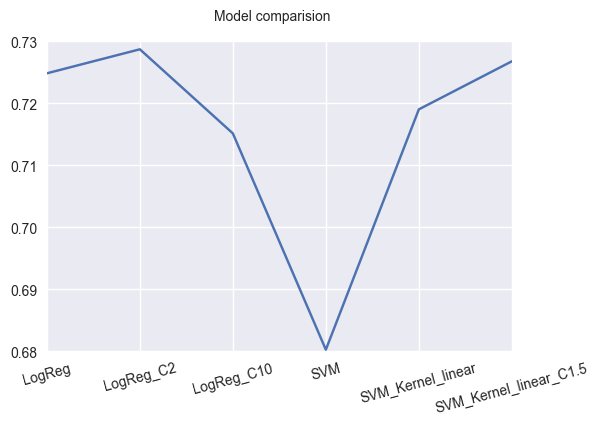

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle('Model comparision')
ax = fig.add_subplot(111)
plt.plot(results)
ax.set_xticklabels(names, rotation='15')

## Using Stochastic Gradient Descent

We can learn the coefficients for a logistic regression model using stochastic gradient descent.

In [24]:
# Step 1: import the class
from sklearn.linear_model import SGDClassifier

# Step 2: instantiate the object
sgd_logreg = SGDClassifier()

print(sgd_logreg)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [25]:
# fit the model
sgd_logreg.fit(df_X_train, df_y_train)

# predict on test
y_pred = sgd_logreg.predict(df_X_test)

# calculate accuracy
print(metrics.accuracy_score(df_y_test, y_pred))

0.686046511628


### Tune SGDClassifier

In [26]:
# Step 2: instantiate the object
sgd_logreg = SGDClassifier(n_iter=1000)

# fit the model
sgd_logreg.fit(df_X_train, df_y_train)

# predict on test
y_pred = sgd_logreg.predict(df_X_test)

# calculate accuracy
print(metrics.accuracy_score(df_y_test, y_pred))


0.701550387597


### Check the coefficients

In [33]:
print(len(sgd_logreg.coef_[0]))

397


In [56]:
coefs = []
for coef in sgd_logreg.coef_[0]:
    coefs.append(round(float(str(coef).format("%.2f")), 2))
coefs.sort()
print(coefs)

[-8117.21, -4565.34, -3189.97, -2882.38, -2584.71, -2364.36, -1058.26, -1056.09, -1044.42, -973.31, -910.37, -698.53, -640.55, -342.09, -314.85, -303.02, -272.3, -264.7, -260.63, -250.29, -239.58, -239.58, -231.34, -207.69, -195.39, -194.16, -165.72, -160.73, -138.29, -129.89, -129.08, -120.04, -116.13, -103.54, -97.5, -91.13, -89.43, -81.55, -70.1, -68.19, -60.48, -60.45, -58.02, -57.26, -48.26, -40.77, -40.51, -39.71, -39.71, -37.24, -35.95, -35.7, -35.09, -34.68, -34.68, -33.62, -33.62, -27.1, -26.65, -23.63, -20.91, -20.56, -20.41, -18.23, -18.19, -17.37, -16.91, -16.04, -14.19, -14.02, -11.9, -11.11, -10.95, -10.77, -10.64, -9.88, -9.66, -9.47, -9.43, -8.55, -8.5, -8.16, -7.57, -6.95, -6.64, -6.32, -5.05, -5.05, -4.96, -4.86, -4.37, -4.09, -3.69, -3.68, -3.53, -3.52, -3.52, -3.47, -3.4, -3.4, -3.04, -2.69, -2.63, -2.51, -2.39, -2.38, -2.18, -2.18, -2.16, -1.82, -1.57, -1.37, -1.24, -1.11, -1.05, -1.03, -1.02, -0.89, -0.87, -0.83, -0.82, -0.78, -0.75, -0.71, -0.71, -0.68, -0.62, -0

In [57]:
# map the coef to the feature.

# Step 2: instantiate the object
sgd_logreg = SGDClassifier(n_iter=1000)

# fit the model
sgd_logreg.fit(df_X_train, df_y_train)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=1000, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [69]:
coefs = list(sgd_logreg.coef_[0])

In [76]:
features = list(df_X_train.columns)

In [77]:
list(zip(features, coefs))

[('avg_age_media_collection', 5357.8465881049306),
 ('Read Score', 3067.0169898376435),
 ('Avg_State_Size_EnglishII', 0.087209344578170506),
 ('lea_cte_courses', -4.9297085567100254),
 ('szip_ad', -2697.8259194895586),
 ('st_wap_num', 541.45859566791819),
 ('sat_participation_pct', -0.64786853094419683),
 ('st_total_specialized_courses', 0.0046736192071795621),
 ('Avg_Dist_Size_04', -195.21811783826431),
 ('st_supplies_expense_pct', 0.00036337226907568929),
 ('RETAINED_School_Pct', -17.199422092735176),
 ('Avg_Class_Size_07', 83.43511794337455),
 ('services_expense_pct', -5.1183745728556334),
 ('st_long_susp_per_c_num', 0.26807183530614032),
 ('Avg_Class_Size_04', 20.867258172121247),
 ('st_prinyrs_0thru3_pct', 0.0020833343427008747),
 ('st_emer_prov_teach_pct', -0.073037826084202964),
 ('other_expense_pct', 0.0),
 ('Avg_Class_Size_00', -70.484530273520491),
 ('GCE_ALL_School_Pct', 8.7228385285134973),
 ('st_wap_per_classroom', 0.0054263592181973894),
 ('lea_sat_participation_pct', 68.

In [92]:
zipped = list(zip(features, coefs))
coef_features = dict(zipped)

In [100]:
import operator
sorted_coef_features = sorted(coef_features.items(), key=operator.itemgetter(1))

# print features that have weights greater than 1000
for feature, weight in sorted_coef_features:
    if (abs(weight) >= 1000):
        print(feature, weight)

wap_num -7937.93020249
lea_federal_perpupil_num -5064.1207675
state_perpupil_num -3084.64667376
total_expense_num -2748.02943218
szip_ad -2697.82591949
lea_books_per_student -2380.49068822
st_avg_student_num -1211.37171094
Avg_Class_Size_EnglishII -1054.72434822
Avg_Class_Size_MathI -1051.98694379
local_perpupil_num 1560.63299934
Science Score 1752.87391127
The ACT Score 1907.13270694
Math SPG Score 1961.92440016
Reading  SPG Score 2395.10774957
Math Score 2591.06714684
SchoolWeightedScore 2597.28507621
SPG Score 2835.3938156
lea_state_perpupil_num 2992.17334892
Read Score 3067.01698984
Overall Achievement Score 3830.60747607
avg_age_media_collection 5357.8465881
short_susp_per_c_num 5528.57452935
sat_avg_score_num 5936.74221741
lea_short_susp_per_c_num 7333.36881462
lea_wap_num 10731.1292302
lea_sat_avg_score_num 16196.2917617
